In [8]:
pip install mesa


[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
class Patch(Agent):
    def __init__(self, unique_id, model, nectar_amount, quality, size):
        super().__init__(unique_id, model)
        self.nectar_amount = nectar_amount
        self.initial_nectar_amount = nectar_amount
        self.quality = quality  # High, Moderate, Low, or Highest
        self.size = size
        self.bees_traveling = 0  # Track number of bees traveling to this patch
        self.cumulative_bees = set()  # Track unique bees that have visited this patch
        self.visits = 0
        self.profitability = self.set_profitability()  # Set initial profitability based on quality

    def set_profitability(self):
        # Set profitability based on patch quality
        if self.quality == "highest":
            return 1.0
        elif self.quality == "high":
            return 0.75
        elif self.quality == "moderate":
            return 0.5
        elif self.quality == "low":
            return 0.25

    def update_profitability(self):
        if self.visits > 0:
            nectar_ratio = self.nectar_amount / self.initial_nectar_amount
            slow_decay_factor = 0.999999999  # A factor closer to 1 will make the decrease slower
            self.profitability = max(0, (nectar_ratio ** 0.75) * self.profitability * slow_decay_factor)
        self.visits += 1

    def add_bee_visit(self, bee_id):
        self.cumulative_bees.add(bee_id)  # Add the bee's ID to the set of visitors

class PatchCell(Agent):
    def __init__(self, unique_id, model, parent_patch):
        super().__init__(unique_id, model)
        self.parent_patch = parent_patch

In [11]:
# Bee class representing a bee with different roles
class Bee(Agent):
    def __init__(self, unique_id, model, speed, role="novice"):
        super().__init__(unique_id, model)
        self.speed = speed
        self.has_food = False 
        self.role = role
        self.patch = None
        self.nectar_collected = 0
        self.waggle_time = 0
        self.communicated = False
        self.novice_target_distance = None
        self.target_pos = None
        self.failed_trips = np.random.randint(1, 6) if role == "recruit" else 0
        self.failed_trip_distance = None
        self.recruit_state = "outbound"
        self.released = False
        self.steps_waited = 0

    def step(self):
        if self.role == "novice":
            self.novice_behavior()
        elif self.role == "scout":
            self.scout_behavior()
        elif self.role == "recruit":
            self.recruit_behavior()
        elif self.role == "employed":
            self.employed_behavior()

    def novice_behavior(self):
        if not self.released:
            return
        if self.communicated:
            self.role = "recruit"
            self.target_pos = self.patch.pos if self.patch else None
        else:
            if self.novice_target_distance is None:
                self.novice_target_distance = self.model.distance_from_hive + np.random.randint(1, 6)
            self.travel_straight_line_as_novice()
            self.find_patch()

    def recruit_behavior(self):
        if self.recruit_state == "outbound":
            self.perform_outbound_behavior()
        elif self.recruit_state == "returning":
            self.perform_returning_behavior()
        elif self.recruit_state == "heading_to_patch":
            self.travel_straight_line_as_recruit()

    def scout_behavior(self):
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos:
                self.perform_waggle()
                self.model.total_nectar_collected += self.nectar_collected
                self.nectar_collected = 0
                self.has_food = False
        else:
            self.random_move()
            if not self.patch:
                self.find_patch()
                if not self.patch and np.linalg.norm(np.array(self.pos) - np.array(self.model.hive_pos)) > self.model.distance_from_hive:
                    self.return_to_hive()
            elif self.patch.nectar_amount > 0:
                self.move_straight_line(self.patch.pos)
                self.collect_nectar()

    def employed_behavior(self):
        if self.has_food:
            self.return_to_hive()
            if self.pos == self.model.hive_pos and self.patch:
                if self.patch.bees_traveling > 0:  # Ensure bees_traveling does not go negative
                    self.patch.bees_traveling -= 1  # Bee has returned, decrease the count
                self.nectar_collected = 0
                self.has_food = False
                self.steps_waited += 1
                if self.steps_waited >= 10:
                    self.steps_waited = 0
                    self.perform_waggle()

            # 10% chance to listen to waggle dance and change patch
            if np.random.random() < 0.1:
                waggle_bee = np.random.choice(
                    [agent for agent in self.model.schedule.agents 
                     if isinstance(agent, Bee) and agent.role in ["employed", "scout"] and agent.patch]
                )
                if waggle_bee and waggle_bee.patch and self.patch and waggle_bee.patch.quality > self.patch.quality:
                    if self.patch.bees_traveling > 0:  # Ensure bees_traveling does not go negative
                        self.patch.bees_traveling -= 1  # Leaving the current patch, decrease the count
                    self.patch = waggle_bee.patch
                    self.target_pos = self.patch.pos
                    self.patch.bees_traveling += 1  # Moving to the new patch, increase the count
        else:
            if self.patch and not self.has_food:
                if self.patch.profitability < 0.1 and np.random.random() < 0.5:
                    if self.patch.bees_traveling > 0:  # Ensure bees_traveling does not go negative
                        self.patch.bees_traveling -= 1  # Bee leaves the patch
                    self.patch = None 
                    self.role = "novice"
                else:
                    self.move_straight_line(self.patch.pos)
                    self.collect_nectar()

    def collect_nectar(self):
        nectar_amount = 2 #Set to to 2 as we are not tracking enctar count to minimun nectar gathered
        if self.patch:
            self.nectar_collected = min(self.patch.nectar_amount, nectar_amount)
            self.patch.nectar_amount -= self.nectar_collected
            self.has_food = True
            self.patch.add_bee_visit(self.unique_id)  # Track the bee visit
            self.patch.update_profitability()  # Update the profitability of the patch after collecting nectar
            if self.patch.nectar_amount <= 0:
                self.patch.nectar_amount = 0
                self.role = "novice"
                if self.patch.bees_traveling > 0:  # Ensure bees_traveling does not go negative
                    self.patch.bees_traveling -= 1  # Leaving the patch, decrease the count
                self.patch = None  # Bee is no longer tied to the patch

    def leave_hive(self):
        if self.patch:
            self.move_straight_line(self.patch.pos)
            self.patch.bees_traveling += 1  # Increase count when bee leaves hive to travel to patch

    def perform_waggle(self):
        if self.model.use_waggle_dance and self.patch:
            # Set waggle time proportional to distance 
            self.waggle_time = int(np.linalg.norm(np.array(self.patch.pos) - np.array(self.model.hive_pos)) * 1000 / self.speed)
            
            # Modify the number of bees attracted based on patch quality
            if self.patch.quality == "highest":
                max_recruits = np.random.randint(8, 11)  # Highest quality patch attracts more bees
            elif self.patch.quality == "high":
                max_recruits = np.random.randint(5, 8)  # Maximum for high quality
            elif self.patch.quality == "moderate":
                max_recruits = np.random.randint(3, 5)  # Moderate number for moderate quality
            elif self.patch.quality == "low":
                max_recruits = np.random.randint(0, 3)  # Fewer recruits for low quality

            novices_in_hive = [agent for agent in self.model.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.model.hive_pos]
            num_to_communicate = min(len(novices_in_hive), max_recruits)  # Randomly choose how many to recruit, up to the max

            for agent in np.random.choice(novices_in_hive, num_to_communicate, replace=False):
                agent.role = "recruit"
                agent.patch = self.patch
                agent.target_pos = self.patch.pos
                self.patch.bees_traveling += 1  # Increase count when novice starts traveling

    def perform_outbound_behavior(self):
        if self.failed_trip_distance is None:
            self.failed_trip_distance = self.model.distance_from_hive + np.random.randint(1, 6)
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.failed_trip_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.failed_trip_distance * np.sin(angle))
            )
        self.travel_straight_line_as_recruit()

    def perform_returning_behavior(self):
        self.return_to_hive()
        if self.pos == self.model.hive_pos:
            self.returning_to_hive = False
            self.failed_trips -= 1
            self.failed_trip_distance = None
            self.target_pos = None
            if self.failed_trips > 0:
                self.recruit_state = "outbound"
            else:
                self.recruit_state = "heading_to_patch"
                if self.patch: 
                    self.target_pos = self.patch.pos
                    self.patch.bees_traveling += 1  # Increase count when returning to patch

    def travel_straight_line_as_recruit(self):
        if self.target_pos is None:
            return
        
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            if self.recruit_state == "outbound":
                # Check if there's a patch in the current position or surroundings
                for agent in self.model.grid.get_cell_list_contents([self.pos]):
                    if isinstance(agent, Patch) and agent.nectar_amount > 0:
                        self.patch = agent
                        self.collect_nectar()
                        self.role = "employed"
                        return  # Start foraging immediately if a patch is found

                # If no patch is found, continue as planned
                self.recruit_state = "returning"
            
            elif self.recruit_state == "heading_to_patch":
                # Existing behavior to finalize traveling to the patch
                for agent in self.model.grid.get_cell_list_contents([self.target_pos]):
                    if isinstance(agent, Patch):
                        self.patch = agent
                        self.collect_nectar()
                        self.role = "employed"
                        break


    def move_straight_line(self, target):
        if target:
            direction = np.arctan2(target[1] - self.pos[1], target[0] - self.pos[0])
            new_position = (
                int(round(self.pos[0] + self.speed * np.cos(direction))),
                int(round(self.pos[1] + self.speed * np.sin(direction)))
            )
            if 0 <= new_position[0] < self.model.grid.width and 0 <= new_position[1] < self.model.grid.height:
                self.model.grid.move_agent(self, new_position)

    def random_move(self):
        angle = np.deg2rad(self.random.choice(range(0, 360, 5)))
        target = (self.pos[0] + self.speed * np.cos(angle), self.pos[1] + self.speed * np.sin(angle))
        target = (int(round(target[0])), int(round(target[1])))
        if 0 <= target[0] < self.model.grid.width and 0 <= target[1] < self.model.grid.height:
            self.model.grid.move_agent(self, target)

    def return_to_hive(self):
        self.move_straight_line(self.model.hive_pos)

    def travel_straight_line_as_novice(self):
        if self.target_pos is None:
            angle = np.random.uniform(0, 2 * np.pi)
            self.target_pos = (
                int(self.model.hive_pos[0] + self.novice_target_distance * np.cos(angle)),
                int(self.model.hive_pos[1] + self.novice_target_distance * np.sin(angle))
            )
        if np.linalg.norm(np.array(self.pos) - np.array(self.target_pos)) > self.speed:
            self.move_straight_line(self.target_pos)
        else:
            self.return_to_hive()
            self.novice_target_distance = None
            self.target_pos = None

    def find_patch(self):
        for patch in self.model.grid.get_cell_list_contents([self.pos]):
            if isinstance(patch, Patch) and patch.nectar_amount > 0:
                self.patch = patch
                self.role = "scout"  # Mark the bee as having found a patch
                break

In [12]:
# HoneybeeModel class
class HoneybeeModel(Model):
    def __init__(self, N, width, height, distance_from_hive, patch_size, use_waggle_dance, speed):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.hive_pos = (width // 2, height // 2)
        self.distance_from_hive = distance_from_hive
        self.patch_size = patch_size
        self.use_waggle_dance = use_waggle_dance
        self.speed = speed
        self.step_count = 0
        self.total_nectar_collected = 0

        # Create initial patches at angles 45°, 135°, 225°
        angles = [45, 135, 225]
        qualities = ["high", "moderate", "low"]
        np.random.shuffle(qualities)

        self.patches = {}
        for i in range(3):
            patch = Patch(self.num_agents + i, self, patch_size, qualities[i], size=3)
            angle = np.deg2rad(angles[i])
            x = int(self.hive_pos[0] + (distance_from_hive * np.cos(angle) * (width / 400)))
            y = int(self.hive_pos[1] + (distance_from_hive * np.sin(angle) * (height / 400)))
            self.place_patch(patch, x, y)
            self.patches[qualities[i]] = patch

        # Create bees
        num_novices = int(0.9 * self.num_agents)
        num_scouts = self.num_agents - num_novices

        for i in range(num_novices):
            bee = Bee(i, self, speed, role="novice")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        for i in range(num_scouts):
            bee = Bee(num_novices + i, self, speed, role="scout")
            self.schedule.add(bee)
            self.grid.place_agent(bee, self.hive_pos)

        self.datacollector = DataCollector(
            model_reporters={
                "High Quality Traveling": lambda m: m.patches["high"].bees_traveling,
                "Moderate Quality Traveling": lambda m: m.patches["moderate"].bees_traveling,
                "Low Quality Traveling": lambda m: m.patches["low"].bees_traveling,
                "Highest Quality Traveling": lambda m: m.patches.get("highest", Patch).bees_traveling if "highest" in m.patches else 0,
                "High Quality Profitability": lambda m: m.patches["high"].profitability,
                "Moderate Quality Profitability": lambda m: m.patches["moderate"].profitability,
                "Low Quality Profitability": lambda m: m.patches["low"].profitability,
                "Highest Quality Profitability": lambda m: m.patches.get("highest", Patch).profitability if "highest" in m.patches else 0,
                "Cumulative Bees to High": lambda m: len(m.patches["high"].cumulative_bees),
                "Cumulative Bees to Moderate": lambda m: len(m.patches["moderate"].cumulative_bees),
                "Cumulative Bees to Low": lambda m: len(m.patches["low"].cumulative_bees),
                "Cumulative Bees to Highest": lambda m: len(m.patches.get("highest", Patch).cumulative_bees) if "highest" in m.patches else 0,
                "Step": lambda m: m.schedule.time
            },
            agent_reporters={"Role": "role"}
        )

    def place_patch(self, patch, x, y):
        size = patch.size
        # Place the patch in a grid area proportional to its size
        for dx in range(size):
            for dy in range(size):
                if 0 <= x + dx < self.grid.width and 0 <= y + dy < self.grid.height:
                    patch_cell = PatchCell(self.num_agents + len(self.schedule.agents), self, patch)
                    self.schedule.add(patch_cell)
                    self.grid.place_agent(patch_cell, (x + dx, y + dy))
        self.grid.place_agent(patch, (x, y))

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.step_count += 1

        for patch in self.patches.values():
            patch.update_profitability()

        if self.step_count >= 5 and self.step_count % 5 == 0:
            self.release_novice()

        if self.schedule.time == 500:
            self.add_highest_quality_patch()

    def add_highest_quality_patch(self):
        # Add the highest quality patch at angle 315°
        angle = np.deg2rad(315)
        x = int(self.hive_pos[0] + (self.distance_from_hive * np.cos(angle) * (self.grid.width / 400)))
        y = int(self.hive_pos[1] + (self.distance_from_hive * np.sin(angle) * (self.grid.height / 400)))
        highest_quality_patch = Patch(self.num_agents + len(self.patches), self, self.patch_size, "highest", size=3)
        self.place_patch(highest_quality_patch, x, y)
        self.patches["highest"] = highest_quality_patch

    def release_novice(self):
        num_novices_in_hive = sum(1 for agent in self.schedule.agents if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos)
        if num_novices_in_hive > 20:
            for agent in self.schedule.agents:
                if isinstance(agent, Bee) and agent.role == "novice" and agent.pos == self.hive_pos and not agent.released:
                    agent.released = True
                    agent.leave_hive()
                    break  # Only one novice is released

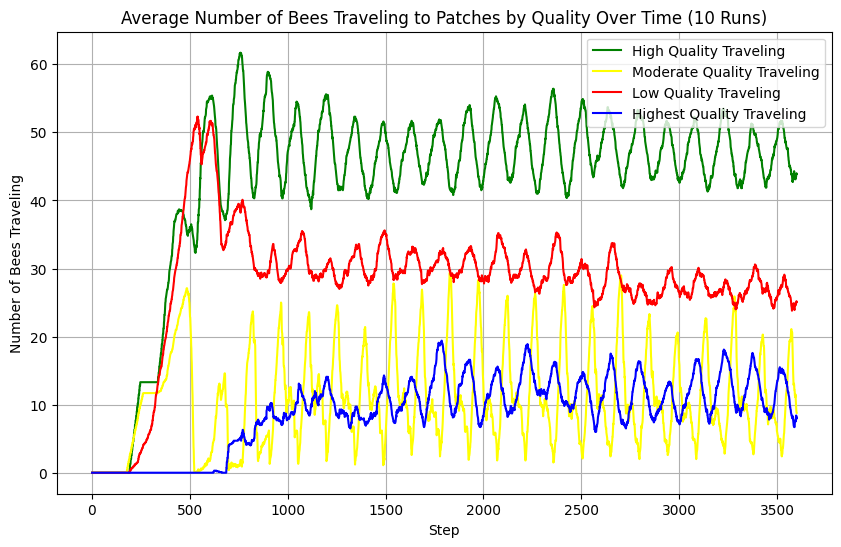

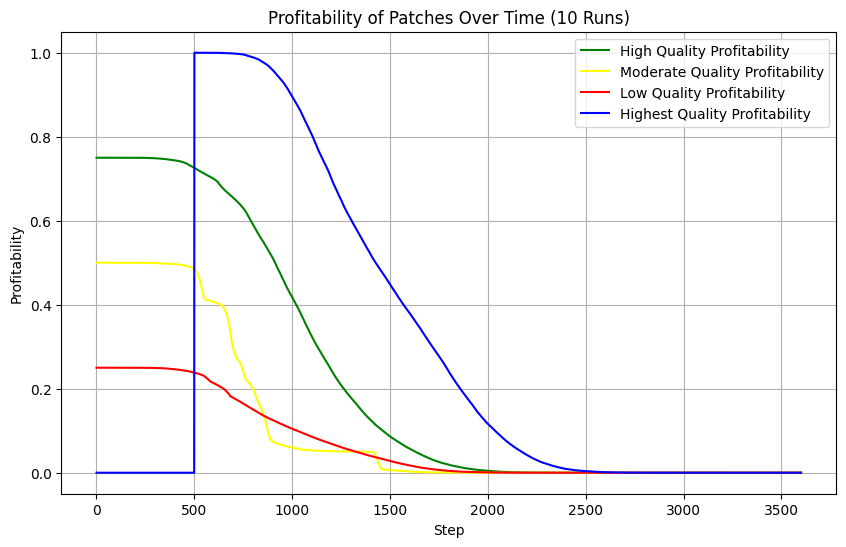

In [13]:
# Function to run the model multiple times and get average results
def run_multiple_simulations(runs, steps):
    results = []
    
    for _ in range(runs):
        # Create model instance
        model = HoneybeeModel(num_bees, width, height, distance_from_hive_km, patch_size, True, bee_speed)
        
        for _ in range(steps):
            model.step()
        
        # Collect the data for this run
        data = model.datacollector.get_model_vars_dataframe()
        results.append(data)
    
    # Combine results from all runs
    combined_results = pd.concat(results).groupby(level=0).mean()
    return combined_results

# Parameters for simulation
num_bees = 200
width = 400
height = 400
distance_from_hive_km = 100
patch_size = 382000
bee_speed = 1

# Number of runs and steps
runs = 10
steps = 3600

# Run multiple simulations and average results
average_results = run_multiple_simulations(runs, steps)

# Plot the averaged results
plt.figure(figsize=(10, 6))
plt.plot(average_results['Step'], average_results['High Quality Traveling'], label='High Quality Traveling', color='green')
plt.plot(average_results['Step'], average_results['Moderate Quality Traveling'], label='Moderate Quality Traveling', color='yellow')
plt.plot(average_results['Step'], average_results['Low Quality Traveling'], label='Low Quality Traveling', color='red')
plt.plot(average_results['Step'], average_results['Highest Quality Traveling'], label='Highest Quality Traveling', color='blue')

plt.title('Average Number of Bees Traveling to Patches by Quality Over Time ({} Runs)'.format(runs))
plt.xlabel('Step')
plt.ylabel('Number of Bees Traveling')
plt.legend()
plt.grid(True)
plt.show()

# Plot the profitability of patches over time
plt.figure(figsize=(10, 6))
plt.plot(average_results['Step'], average_results['High Quality Profitability'], label='High Quality Profitability', color='green')
plt.plot(average_results['Step'], average_results['Moderate Quality Profitability'], label='Moderate Quality Profitability', color='yellow')
plt.plot(average_results['Step'], average_results['Low Quality Profitability'], label='Low Quality Profitability', color='red')
plt.plot(average_results['Step'], average_results['Highest Quality Profitability'], label='Highest Quality Profitability', color='blue')

plt.title('Profitability of Patches Over Time ({} Runs)'.format(runs))
plt.xlabel('Step')
plt.ylabel('Profitability')
plt.legend()
plt.grid(True)
plt.show()